# Data analysis Project on Energy Consumption Dataset

### Libraries and Configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### Data loading

In [2]:
path = kagglehub.dataset_download("mrsimple07/energy-consumption-prediction")
print("Path to dataset files:", path)

Path to dataset files: /Users/nameisalfio/.cache/kagglehub/datasets/mrsimple07/energy-consumption-prediction/versions/1


In [3]:
df = pd.read_csv(path + "/Energy_consumption.csv")

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB
None
       Temperature     Humidity  SquareFootage    Occupancy  RenewableEnergy  \
count  1000.000000  1000.000000    1000.000000  1000.000000      1000.000000   
mean     24.982026    45.395412    1500.05

### Data Preprocessing & Time Engineering

We need to transform the timestamp into a machine-readable format and handle categorical variables.

In [4]:
print(f'Missing values for each column: {df.isna().sum()}')

Missing values for each column: Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64


In [5]:
# 1. Convert Timestamp to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# 2. Extract temporal features
# These are essential for identifying daily and weekly patterns
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek_Num'] = df['Timestamp'].dt.dayofweek # 0=Monday, 6=Sunday

# 3. Check for missing values explicitly
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("Data Integrity Check: No missing values found.")
else:
    print(f"Missing values found:\n{missing_data[missing_data > 0]}")

# 4. Brief look at the updated dataframe
print("\nFirst 5 rows with new temporal features:")
print(df[['Timestamp', 'Hour', 'DayOfWeek', 'EnergyConsumption']].head())

Data Integrity Check: No missing values found.

First 5 rows with new temporal features:
            Timestamp  Hour  DayOfWeek  EnergyConsumption
0 2022-01-01 00:00:00     0     Monday          75.364373
1 2022-01-01 01:00:00     1   Saturday          83.401855
2 2022-01-01 02:00:00     2     Sunday          78.270888
3 2022-01-01 03:00:00     3  Wednesday          56.519850
4 2022-01-01 04:00:00     4     Friday          70.811732


### Univariate Analysis (Target Variable)

Before looking for relationships, we need to understand how energy consumption "moves" on its own. We look for outliers that could compromise future models.

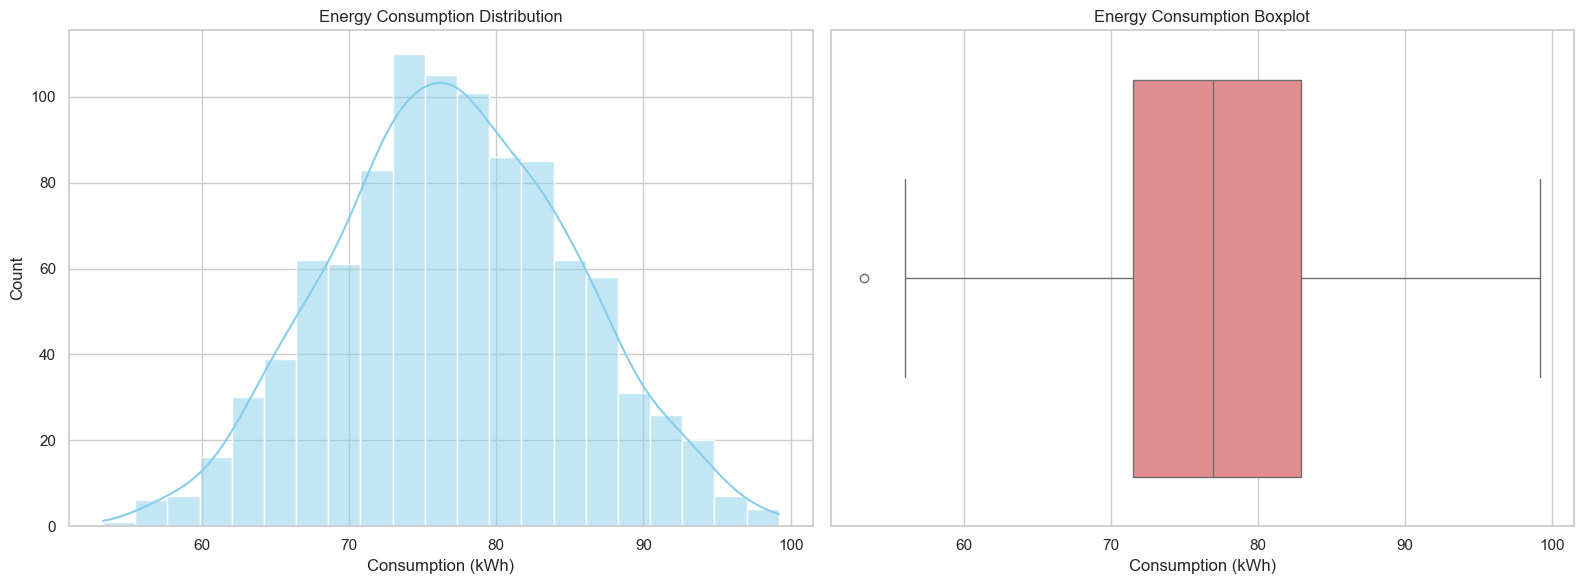

In [6]:
# Setup the visualization grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram & KDE: Check for normality
sns.histplot(df['EnergyConsumption'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Energy Consumption Distribution')
axes[0].set_xlabel('Consumption (kWh)')

# Boxplot: Check for statistical outliers
sns.boxplot(x=df['EnergyConsumption'], ax=axes[1], color='lightcoral')
axes[1].set_title('Energy Consumption Boxplot')
axes[1].set_xlabel('Consumption (kWh)')

plt.tight_layout()
plt.show()

In [7]:
print(f"Skewness: {df['EnergyConsumption'].skew():.2f}")  # should be near 0, indicating symmetry
print(f"Kurtosis (Fisher): {df['EnergyConsumption'].kurt():.2f}")  # should be near 0, indicating a normal distribution

Skewness: 0.03
Kurtosis (Fisher): -0.30


In [8]:
# Quantitative outlier detection using IQR
Q1 = df['EnergyConsumption'].quantile(0.25)
Q2 = df['EnergyConsumption'].quantile(0.5)   # Median
Q3 = df['EnergyConsumption'].quantile(0.75)
Q4 = df['EnergyConsumption'].quantile(1.0)   # Max
mean = df['EnergyConsumption'].mean()
dev_std = df['EnergyConsumption'].std()

IQR = Q3 - Q1  # Interquartile Range
outlier_threshold = 1.5 * IQR

outliers = df[(df['EnergyConsumption'] < Q1 - outlier_threshold) |
              (df['EnergyConsumption'] > Q3 + outlier_threshold)]

print("Statistical Summary for Target Variable:")
print("-" * 50)
print(f"First quantile (Q1): {Q1:.2f}")
print(f"Median (Q2): {Q2:.2f}")
print(f"Third quantile (Q3): {Q3:.2f}")
print(f"Maximum (Q4): {Q4:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {dev_std:.2f}\t Variance: {dev_std**2:.2f}")
print(f"\nPotential outliers detected: {len(outliers)}:\n\n{outliers}")

Statistical Summary for Target Variable:
--------------------------------------------------
First quantile (Q1): 71.54
Median (Q2): 76.94
Third quantile (Q3): 82.92
Maximum (Q4): 99.20
Mean: 77.06
Standard deviation: 8.14	 Variance: 66.33

Potential outliers detected: 1:

             Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
69 2022-01-03 21:00:00    20.735716  48.506636    1836.542651          4   

   HVACUsage LightingUsage  RenewableEnergy DayOfWeek Holiday  \
69       Off            On         9.295439    Friday      No   

    EnergyConsumption  Hour  Day  Month  DayOfWeek_Num  
69          53.263278    21    3      1              0  


### Multivariate Analysis (The "Drivers")

Now let's identify the real drivers of consumption. We will create a correlation matrix to see which numerical variables (Temperature, Humidity, Employment) are most closely related to energy.

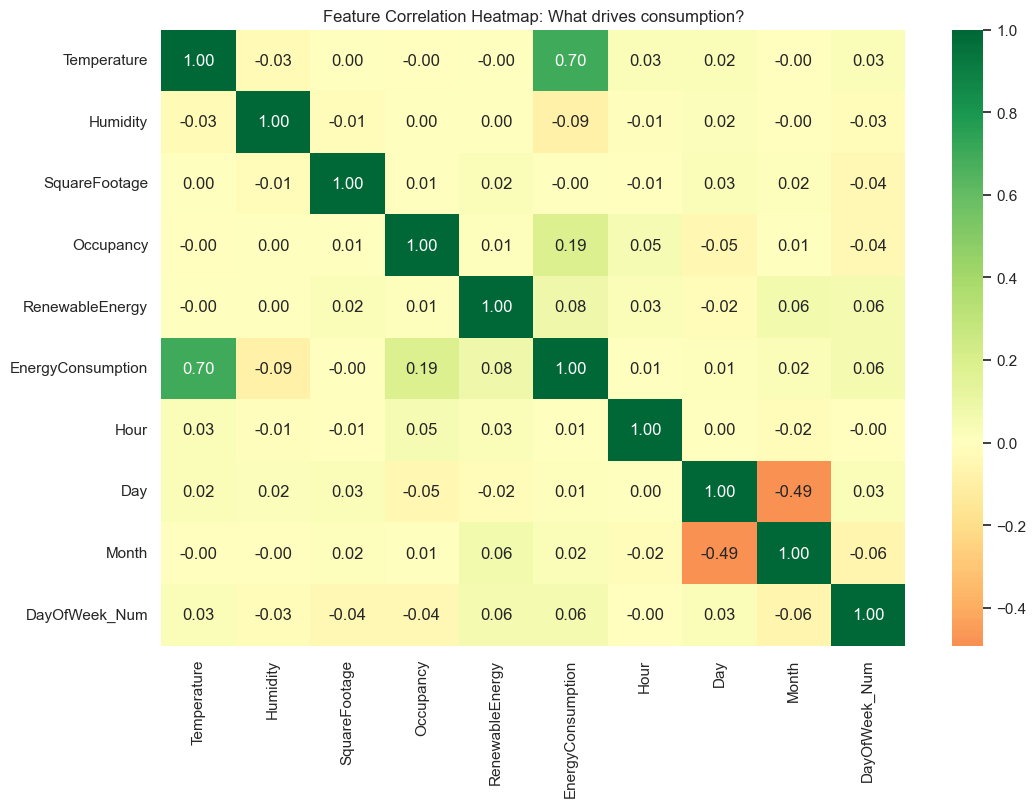

In [9]:
# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap: What drives consumption?')
plt.show()

In [10]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #exclude the upper triangular matrix because of the symmetry 
corr_lower = corr_matrix.mask(mask)

corr_pairs = corr_lower.stack() #convert in tuples
strong_corr = corr_pairs[abs(corr_pairs) >= 0.5].sort_values(key=np.abs, ascending=False)
print("Strong correlations:")
print("-" * 50)
print(strong_corr)

Strong correlations:
--------------------------------------------------
EnergyConsumption  Temperature    0.69641
dtype: float64


### Bivariate Analysis (Deep Dive into Drivers)

We will now visualize the relationship between Temperature and Consumption, and then analyze how categorical variables like HVACUsage and Occupancy shift the consumption baseline.

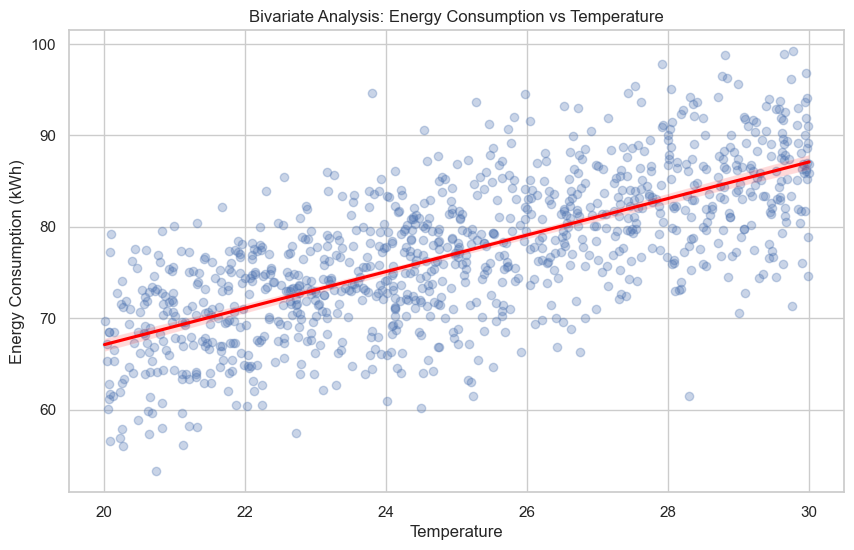

In [11]:
# Visualize the linear relationship between Temperature and Energy Consumption
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Temperature', y='EnergyConsumption', 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Bivariate Analysis: Energy Consumption vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

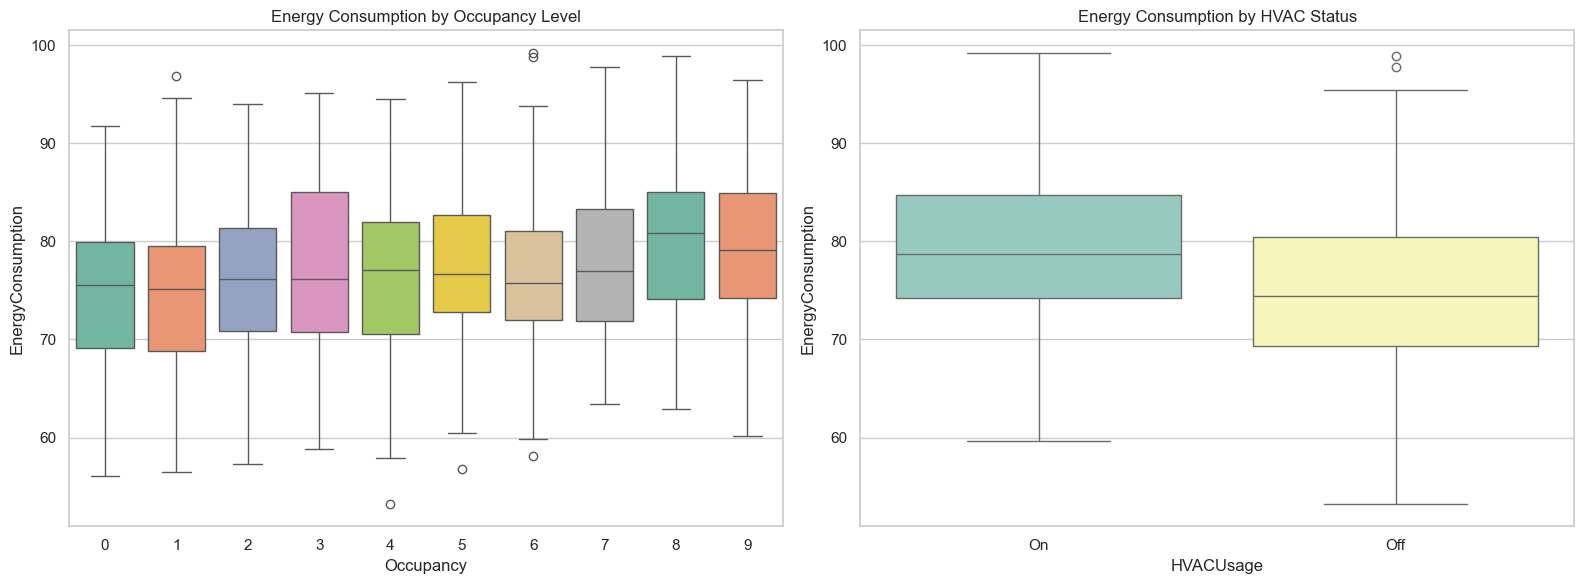

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for Occupancy
sns.boxplot(
    data=df,
    x='Occupancy',
    y='EnergyConsumption',
    hue='Occupancy',     
    palette='Set2',
    ax=axes[0],
    dodge=False,         
    legend=False         
)
axes[0].set_title('Energy Consumption by Occupancy Level')

# Boxplot for HVACUsage
sns.boxplot(
    data=df,
    x='HVACUsage',
    y='EnergyConsumption',
    hue='HVACUsage',     
    palette='Set3',
    ax=axes[1],
    dodge=False,
    legend=False
)
axes[1].set_title('Energy Consumption by HVAC Status')

plt.tight_layout()
plt.show()

- **Occupancy Paradox** : Nota come il consumo mediano per Occupancy = 0 sia molto vicino a quello per Occupancy = 9. Questo è un segnale d'allarme critico: l'edificio consuma quasi la stessa energia sia quando è vuoto che quando è pieno.

- **HVAC Shift** : Il grafico a destra conferma che lo stato "On" del sistema HVAC(Heating, Ventilation, and Air Conditioning) alza l'intero intervallo di consumo, ma esiste un consumo significativo anche quando il sistema è "Off".

### Hourly Load Profile Analysis

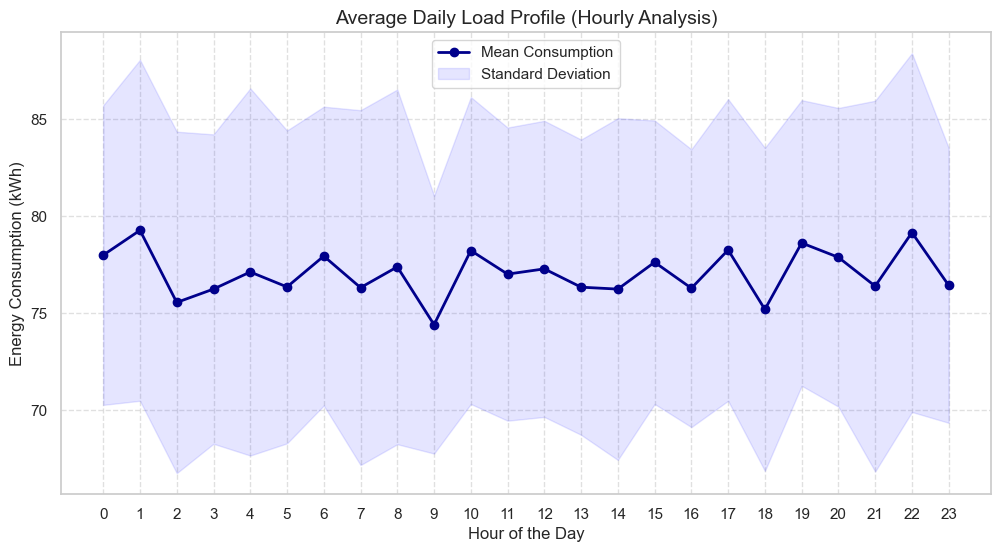

In [13]:
# Create an average hourly profile to identify peak/off-peak patterns
hourly_summary = df.groupby('Hour')['EnergyConsumption'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_summary['Hour'], hourly_summary['mean'], color='darkblue', marker='o', linewidth=2, label='Mean Consumption')
plt.fill_between(hourly_summary['Hour'], 
                 hourly_summary['mean'] - hourly_summary['std'], 
                 hourly_summary['mean'] + hourly_summary['std'], 
                 color='blue', alpha=0.1, label='Standard Deviation')

plt.title('Average Daily Load Profile (Hourly Analysis)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

- **Time-series Insight** : Look for peaks during working hours. A flat line indicates inefficient constant usage.

### Baseload Calculation

In [14]:
# Calculate the empirical Baseload (10th percentile to avoid outliers)
baseload = df['EnergyConsumption'].quantile(0.1)
peak_load = df['EnergyConsumption'].max()
dynamic_ratio = (peak_load - baseload) / peak_load

print(f"--- Energy Efficiency Metrics ---")
print(f"Empirical Baseload: {baseload:.2f} kWh")
print(f"Peak Demand: {peak_load:.2f} kWh")
print(f"Dynamic Ratio: {dynamic_ratio:.2%}")

--- Energy Efficiency Metrics ---
Empirical Baseload: 66.46 kWh
Peak Demand: 99.20 kWh
Dynamic Ratio: 33.00%


- **Logic** : High baseload (>60% of peak) usually suggests poorly configured systems or 24/7 waste.

### Renewable Energy Impact & Net Consumption

We need to understand whether renewable energy production occurs when it is most needed or whether it is wasted.

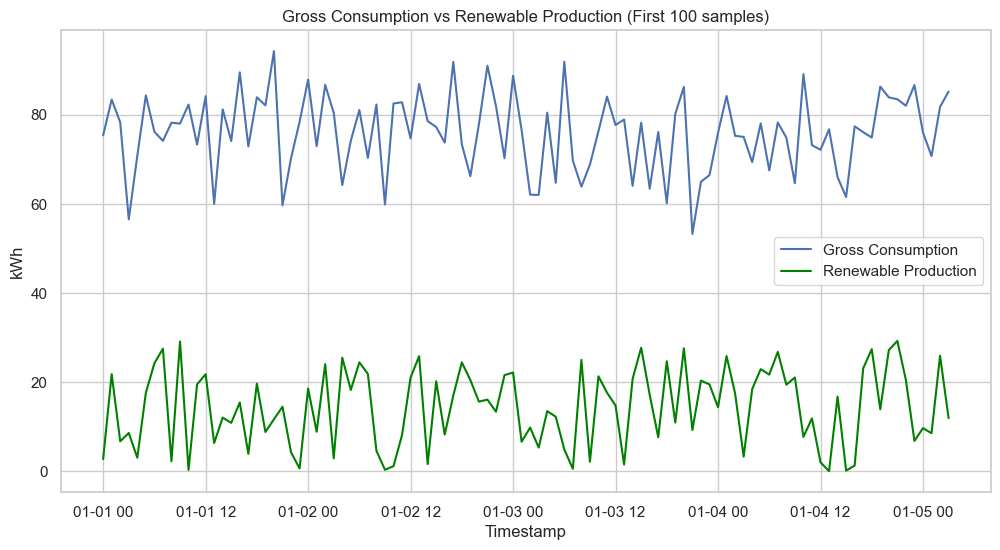

Average Renewable Contribution: 19.64%


In [15]:
# 1. Calculate Net Consumption (Grid reliance)
df['Net_Consumption'] = df['EnergyConsumption'] - df['RenewableEnergy']

# 2. Visualize the offset
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.head(100), x='Timestamp', y='EnergyConsumption', label='Gross Consumption')
sns.lineplot(data=df.head(100), x='Timestamp', y='RenewableEnergy', label='Renewable Production', color='green')
plt.title('Gross Consumption vs Renewable Production (First 100 samples)')
plt.ylabel('kWh')
plt.show()

print(f"Average Renewable Contribution: {(df['RenewableEnergy'].mean() / df['EnergyConsumption'].mean()):.2%}")

### Energy Use Intensity (EUI)

In power engineering, absolute consumption doesn't say it all. A 100m2 building that consumes 80kWh is inefficient compared to a 1000m2 building that consumes the same.

In [16]:
df['EUI'] = df['EnergyConsumption'] / df['SquareFootage']
print(f"Mean EUI: {df['EUI'].mean():.4f} kWh/sqft")

Mean EUI: 0.0534 kWh/sqft


### Holiday and Weekend vs Weekday Analysis

Buildings have different "behaviors" on holidays. If consumption during a Holiday is identical to a working Tuesday, there is a serious error in the system planning (e.g. lights and heating turned on unnecessarily).

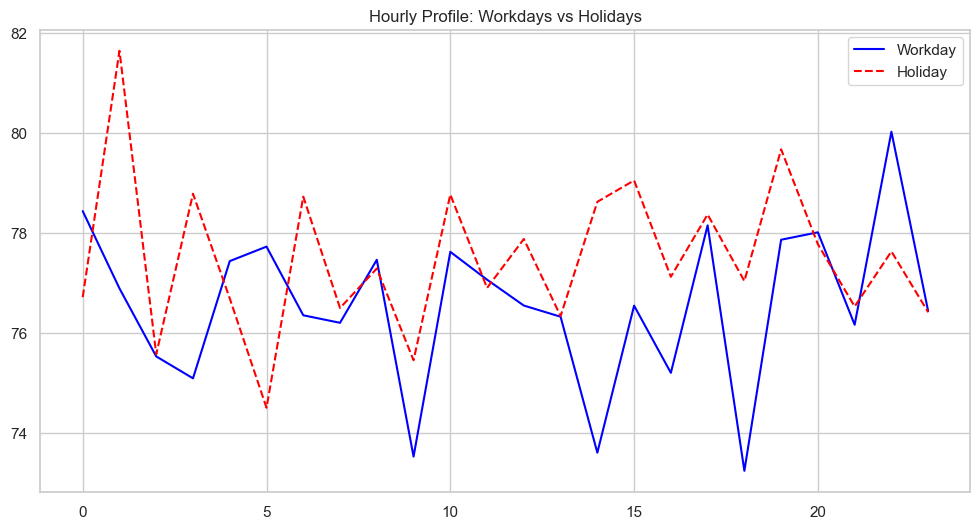

In [17]:
holiday_profile = df[df['Holiday'] == 'Yes'].groupby('Hour')['EnergyConsumption'].mean()
workday_profile = df[df['Holiday'] == 'No'].groupby('Hour')['EnergyConsumption'].mean()

plt.figure(figsize=(12, 6))
plt.plot(workday_profile, label='Workday', color='blue')
plt.plot(holiday_profile, label='Holiday', color='red', linestyle='--')
plt.legend()
plt.title('Hourly Profile: Workdays vs Holidays')
plt.show()

In a properly managed building, we would expect the blue line (Workday) to be consistently above the red line (Holiday), especially during working hours. Instead, let's observe the opposite:

- Higher consumption on holidays: The red line shows consumption peaks (especially around 1, 10 and 19 am) that significantly exceed working day levels.

- Management Inconsistency: This suggests that systems (HVAC, lights) are not turned off or reduced during holidays. On the contrary, they appear to operate under higher loads, which is a clear sign of massive energy waste or incorrect timer scheduling.

## Predictive Modelling
___

### Data preprocessing 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Encoding categorical variables
le = LabelEncoder()
df_ml = df.copy()
categorical_cols = ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']

for col in categorical_cols:
    df_ml[col] = le.fit_transform(df_ml[col])

# 2. Feature Selection
# We exclude Timestamp and the Target
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
            'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'Hour', 'DayOfWeek_Num']
X = df_ml[features].values
y = df_ml['EnergyConsumption'].values.reshape(-1, 1)

# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# 5. Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)
print(f"Data prepared: {X_train_t.shape[0]} samples for training, {X_test_t.shape[0]} for testing.")

Data prepared: 800 samples for training, 200 for testing.


### Definition of Regression model

In [19]:
class EnergyRegressor(nn.Module):
    def __init__(self, input_dim):
        super(EnergyRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32), 
            nn.ReLU(),
            
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)

### Training Loop

We will use the MSE loss function defined as:

$$
MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y_i})^2
$$

In [38]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=len(test_ds)) 
print(f"Batches in training loader: {len(train_loader)}")

Batches in training loader: 25


In [59]:
model = EnergyRegressor(X_train_t.shape[1])
print(model)
print('-' * 50)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    # --- Training phase ---
    model.train()
    running_train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass on the mini-batch
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Average training loss for the batch
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # --- Validation phase ---
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for val_X, val_y in val_loader:
            prediction = model(val_X)
            v_loss = criterion(prediction, val_y)
            running_val_loss += v_loss.item()
            
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Avg Train Loss: {epoch_train_loss:.4f} | Avg Val Loss: {epoch_val_loss:.4f}")

EnergyRegressor(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
--------------------------------------------------
Epoch [50/50] | Avg Train Loss: 0.3808 | Avg Val Loss: 0.4233


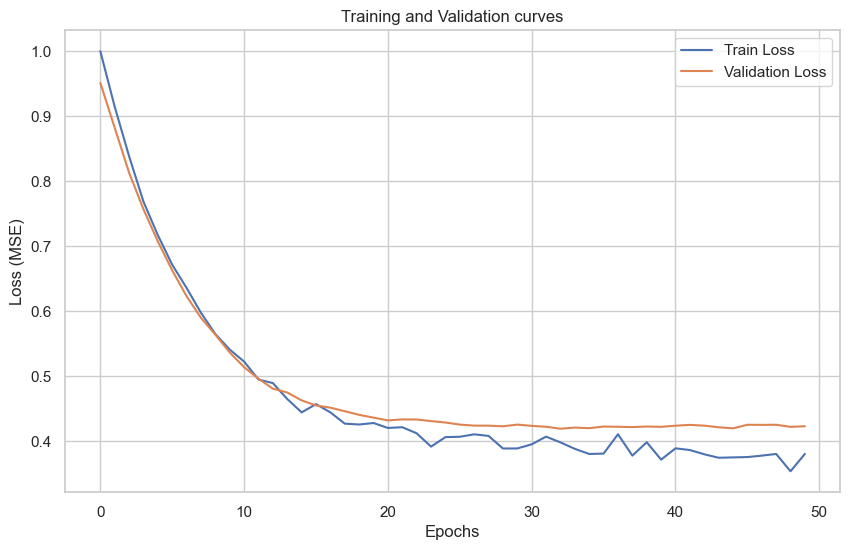

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

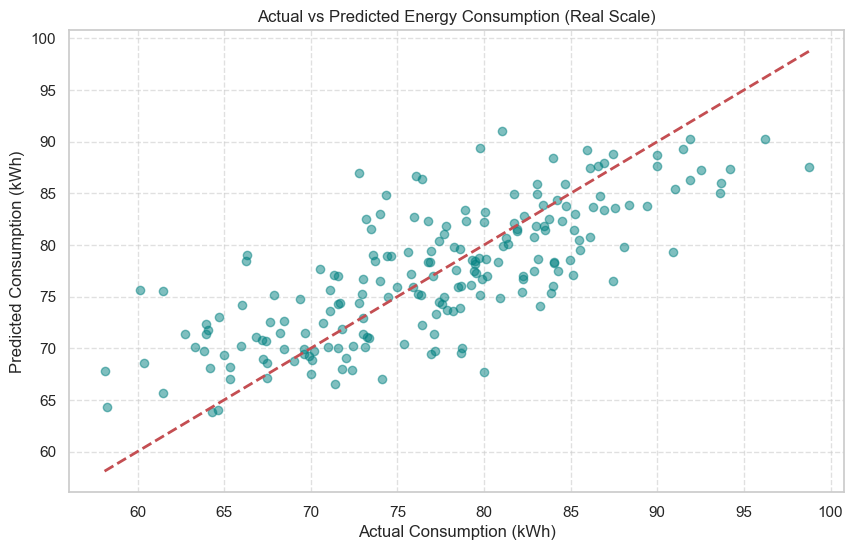

Mean Absolute Error: 4.21 kWh


In [61]:
model.eval()

with torch.no_grad():
    predictions_scaled = model(X_test_t)
    predictions_numpy = predictions_scaled.cpu().numpy()
    actuals_numpy = y_test_t.cpu().numpy()
    predictions_kwh = scaler_y.inverse_transform(predictions_numpy)
    actuals_kwh = scaler_y.inverse_transform(actuals_numpy)

# Visualizing Predictions vs Actual (in kWh)
plt.figure(figsize=(10, 6))
plt.scatter(actuals_kwh, predictions_kwh, alpha=0.5, color='teal')
plt.plot([actuals_kwh.min(), actuals_kwh.max()], [actuals_kwh.min(), actuals_kwh.max()], 'r--', lw=2)

plt.xlabel('Actual Consumption (kWh)')
plt.ylabel('Predicted Consumption (kWh)')
plt.title('Actual vs Predicted Energy Consumption (Real Scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mae_kwh = np.mean(np.abs(predictions_kwh - actuals_kwh))
print(f"Mean Absolute Error: {mae_kwh:.2f} kWh")